# Using Python Libraries (FinQuant, Empyrical) for Portfolio Management

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests
from bs4 import BeautifulSoup
import csv
import time
import finquant
from finquant.portfolio import build_portfolio

%load_ext lab_black

In [926]:
# Read Portfolio from CSV downloaded from brokerage
sch = pd.read_csv("data/positions.CSV", header=2)
sch.drop([18, 19], inplace=True)
# tickers
ticks = sch.Symbol[:-2]

# allocation DF
df_pf = pd.DataFrame(data=sch[["Symbol", "Quantity"]].iloc[:-2])
df_pf.rename(columns={"Symbol": "Name", "Quantity": "Allocation"}, inplace=True)
df_pf.Allocation = df_pf.Allocation.astype("f")

In [968]:
import string

punct = "!\"#$%&'()*+,-/:;<=>?@[\\]^_`{}~"  # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ""))


def castFloat(df, col):
    for c in col:
        df[c] = "|".join(df[c].tolist()).translate(transtab).split("|")
    df = df.astype(dict.fromkeys(col, "f"))
    return df

In [969]:
sch = castFloat(sch, ["Price", "Market Value", "Cost Basis"])

In [858]:
master = dict()

In [861]:
import re
from io import StringIO
from datetime import datetime, timedelta, date


class YFinanceCrawler:
    timeout = 2
    crumb_link = "https://finance.yahoo.com/quote/{0}/history?p={0}"
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = "https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1mo&events=history&crumb={crumb}"

    def __init__(self, tickers, years_back=10):
        self.tickers = tickers
        self.session = requests.Session()
        self.dateto = date.today()
        self.datefrom = date(self.dateto.year - years_back, self.dateto.month, self.dateto.day)

    def get_crumb(self, ticker):
        response = self.session.get(
            self.crumb_link.format(ticker), timeout=self.timeout
        )
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError("Could not get crumb from Yahoo Finance")
        else:
            self.crumb = match.group(1)

    def get_quote(self, ticker):
        if not hasattr(self, "crumb") or len(self.session.cookies) == 0:
            self.get_crumb(ticker)
        url = self.quote_link.format(
            quote=ticker,
            dto=int(time.mktime(self.dateto.timetuple())),
            dfrom=int(time.mktime(self.datefrom.timetuple())),
            crumb=self.crumb,
        )
        response = self.session.get(url)
        response.raise_for_status()

        return pd.read_csv(StringIO(response.text), parse_dates=["Date"])

    def getPeriodIndex(self):
        dateto_str = self.dateto.strftime("%x")
        datefrom_str = self.datefrom.strftime("%x")
        date_index = pd.date_range(start=datefrom_str, end=dateto_str, freq="M")

        return date_index

    def priceDf(self):

        new = dict()
        query = []
        read = []
        for ticker in self.tickers:
            if ticker in master:
                new[ticker] = master[ticker]
                read.append(ticker)
            else:
                data = self.get_quote(ticker)
                query.append(ticker)
                prices = data["Adj Close"]

                master[ticker] = prices
                new[ticker] = prices

        print("queried: ", query)
        print("read: ", read)
        new = pd.DataFrame(data=new)
        date_index = self.getPeriodIndex()
        new.index = date_index

        return new

In [868]:
def stats(pf):
    vol = pf.comp_volatility()
    sha = pf.comp_sharpe()
    ret = pf.comp_expected_return(freq=12)

    print("volatility = {:f}\b".format(vol))
    print("sharpe = {:f}\b".format(sha))
    print("return = {:f}\b".format(ret))

In [511]:
orig = priceDf(ticks)
pf = build_portfolio(data=master, pf_allocation=df_pf)

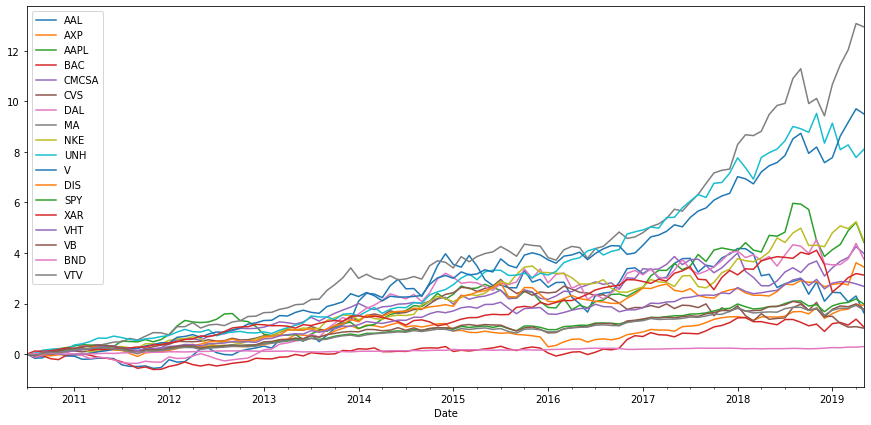

In [155]:
cum_rets = pf.comp_cumulative_returns()
cum_rets.plot(figsize=(15, 7))

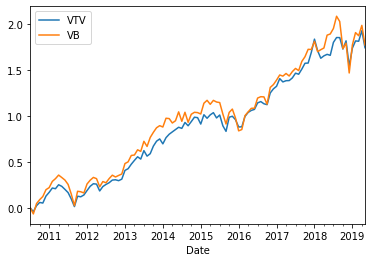

In [175]:
cum_rets[["AAL", "VTV", "VB"]].plot()

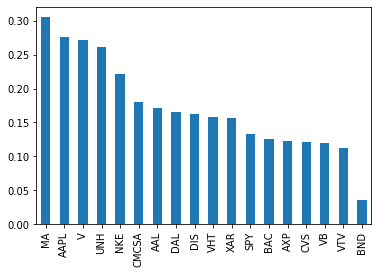

In [178]:
mean_rets = pf.comp_mean_returns(freq=12)
mean_rets.sort_values(ascending=False).plot(kind="bar")

In [148]:
pf.comp_sharpe()

4.5737248686236205

In [150]:
ef = pf.ef_efficient_frontier()

In [157]:
max_sharpe = pf.ef_maximum_sharpe_ratio()

In [159]:
pd.set_option("display.float_format", lambda x: "{:3f}".format(x))
max_sharpe

,Allocation
AAL,0.000000
AXP,0.000000
AAPL,0.006625
BAC,0.000000
CMCSA,0.000000
CVS,0.000000
DAL,0.000000
MA,0.070727
NKE,0.036908
UNH,0.093276


In [164]:
exp_ret = pf.comp_expected_return(freq=12)
exp_vol = pf.comp_volatility()
pf.ef_efficient_volatility(target=exp_vol)

,Allocation
AAL,0.000000
AXP,0.000000
AAPL,0.070445
BAC,0.000000
CMCSA,0.000000
CVS,0.000000
DAL,0.000000
MA,0.631979
NKE,0.000000
UNH,0.297577


In [165]:
max_sharpe = pf.ef_maximum_sharpe_ratio(verbose=False)
max_sharpe

,Allocation
AAL,0.000000
AXP,0.000000
AAPL,0.006625
BAC,0.000000
CMCSA,0.000000
CVS,0.000000
DAL,0.000000
MA,0.070727
NKE,0.036908
UNH,0.093276


## Hypothetical Portfolios

## KO + VGT

In [372]:
rem = ["AAL", "CMCSA", "CVS", "VB"]
add = ["KO", "VGT"]
keep = [t for t in ticks if t not in rem]
hticks1 = keep + add

In [373]:
ha1 = df_pf.loc[df_pf.Name.isin(keep)].append(
    pd.DataFrame([["KO", 1], ["VGT", 1]], columns=["Name", "Allocation"]),
    ignore_index=True,
)

In [374]:
ha1

,Name,Allocation
0,AXP,1.005000
1,AAPL,1.008000
2,BAC,2.000000
3,DAL,2.000000
4,MA,1.002600
5,NKE,1.003100
6,UNH,1.000000
7,V,2.009500
8,DIS,1.000000
9,SPY,1.009700


In [437]:
hpf1 = build_portfolio(data=hmast1)

In [362]:
hmast1.columns

Index(['AXP', 'AAPL', 'BAC', 'DAL', 'MA', 'NKE', 'UNH', 'V', 'DIS', 'SPY',
       'XAR', 'VHT', 'BND', 'VTV', 'KO', 'VGT'],
      dtype='object')

In [365]:
ha1.Name.values

array(['AAL', 'AXP', 'AAPL', 'BAC', 'CMCSA', 'CVS', 'DAL', 'MA', 'NKE',
       'UNH', 'V', 'DIS', 'SPY', 'XAR', 'VHT', 'VB', 'BND', 'VTV', 'KO',
       'VGT'], dtype=object)

In [278]:
h1_ms = hpf1.ef_maximum_sharpe_ratio(verbose=False)
h1_ms

,Allocation
AXP,0.000000
AAPL,0.006621
BAC,0.000000
DAL,0.000000
MA,0.070716
NKE,0.036897
UNH,0.093287
V,0.035154
DIS,0.000000
SPY,0.000000


In [439]:
hpf1.comp_weights()

0    0.062500
1    0.062500
2    0.062500
3    0.062500
4    0.062500
5    0.062500
6    0.062500
7    0.062500
8    0.062500
9    0.062500
10   0.062500
11   0.062500
12   0.062500
13   0.062500
14   0.062500
15   0.062500
Name: Allocation, dtype: float64

In [380]:
hpf1.ef_maximum_sharpe_ratio()

,Allocation
AXP,0.000000
AAPL,0.006621
BAC,0.000000
DAL,0.000000
MA,0.070716
NKE,0.036897
UNH,0.093287
V,0.035154
DIS,0.000000
SPY,0.000000


## ETFs set 1

In [483]:
hticks2 = [
    "SPY",
    "XAR",
    "VHT",
    "BND",
    "VTV",
    "VGT",
    "XLE",
    "AAPL",
    "UNH",
    "MA",
    "V",
    "NKE",
]
ticks = list(ticks)
rem = [t for t in ticks if t not in hticks2]
add = [t for t in hticks2 if t not in ticks]
keep = [t for t in hticks2 if t in ticks]

In [497]:
hmast2 = pd.concat([master.loc[:, keep], priceDf(add)], axis=1)

In [498]:
hmast2

,SPY,XAR,VHT,BND,VTV,AAPL,UNH,MA,V,NKE,VGT,XLE
Date,,,,,,,,,,,,
2010-07,90.553703,21.891249,43.697258,61.466763,36.963882,31.814383,26.103277,17.943613,15.246343,13.902665,47.295860,40.431011
2010-08,86.480568,24.534058,42.801445,62.423424,35.395241,30.064436,27.191977,17.074158,14.338008,13.215457,44.022072,38.448498
2010-09,93.723564,24.234539,46.970470,62.427181,37.818092,35.091660,30.098061,19.281160,15.538717,15.129810,49.597305,42.098106
2010-10,97.824875,24.661795,47.874916,62.628151,39.115501,37.222515,31.017849,20.663555,16.354773,15.608957,52.772968,44.690636
2010-11,97.824875,25.878263,46.772354,62.197666,38.873127,38.480263,31.422239,20.540718,15.452919,16.507853,52.273434,47.308418
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03,256.243225,nan,165.662292,84.658150,88.270271,253.603500,248.304443,241.187042,160.850662,82.534111,211.081207,28.423962
2020-04,290.480011,nan,188.419998,86.974075,98.559998,293.006836,292.470001,274.545471,178.421249,86.963066,242.000000,38.000000
2020-05,304.320007,nan,196.619995,87.576523,101.400002,317.081665,304.850006,300.890015,194.913635,98.334702,261.029999,38.759998


In [499]:
hpf2 = build_portfolio(data=hmast2)

In [500]:
stats(hpf2)

volatility = 0.526523

sharpe = 7.147451

return = 0.179443



In [501]:
stats(hpf1)

volatility = 0.561281

sharpe = 0.302465

return = 0.174768



In [502]:
stats(pf)

volatility = 0.730285

sharpe = 4.589820

return = 0.159851



## ETFs set 2

In [522]:
add = ["VEA", "GLD", "XLF"]
keep = hticks2
hticks3 = keep + add
hticks3

['SPY',
 'XAR',
 'VHT',
 'BND',
 'VTV',
 'VGT',
 'XLE',
 'AAPL',
 'UNH',
 'MA',
 'V',
 'NKE',
 'VEA',
 'GLD',
 'XLF']

In [531]:
hmast3 = priceDf(hticks3)

In [532]:
hmast3

,SPY,XAR,VHT,BND,VTV,VGT,XLE,AAPL,UNH,MA,V,NKE,VEA,GLD,XLF
Date,,,,,,,,,,,,,,,
2010-07,90.553703,21.891249,43.697258,61.466763,36.963882,47.295860,40.431011,31.814383,26.103277,17.943613,15.246343,13.902665,24.025383,115.489998,7.704960
2010-08,86.480568,24.534058,42.801445,62.423424,35.395241,44.022072,38.448498,30.064436,27.191977,17.074158,14.338008,13.215457,23.164440,122.080002,7.102603
2010-09,93.723564,24.234539,46.970470,62.427181,37.818092,49.597305,42.098106,35.091660,30.098061,19.281160,15.538717,15.129810,25.401407,127.910004,7.516397
2010-10,97.824875,24.661795,47.874916,62.628151,39.115501,52.772968,44.690636,37.222515,31.017849,20.663555,16.354773,15.608957,26.431602,132.619995,7.643531
2010-11,97.824875,25.878263,46.772354,62.197666,38.873127,52.273434,47.308418,38.480263,31.422239,20.540718,15.452919,16.507853,25.136505,135.419998,7.591034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03,256.243225,nan,165.662292,84.658150,88.270271,211.081207,28.423962,253.603500,248.304443,241.187042,160.850662,82.534111,33.191494,148.050003,20.644939
2020-04,290.480011,nan,188.419998,86.974075,98.559998,242.000000,38.000000,293.006836,292.470001,274.545471,178.421249,86.963066,35.680000,158.800003,22.790001
2020-05,304.320007,nan,196.619995,87.576523,101.400002,261.029999,38.759998,317.081665,304.850006,300.890015,194.913635,98.334702,37.669998,162.910004,23.410000


In [534]:
hpf3 = build_portfolio(data=hmast3)

In [535]:
stats(hpf3)

volatility = 0.513221

sharpe = 6.553460

return = 0.160399



In [538]:
hpf3.ef_maximum_sharpe_ratio()

,Allocation
SPY,0.000000
XAR,0.132352
VHT,0.000000
BND,0.626762
VTV,0.000000
VGT,0.000000
XLE,0.000000
AAPL,0.006061
UNH,0.089712
MA,0.067786


## ETFs set 3

In [862]:
hticks4 = [
    "VTSAX",
    "XAR",
    "BND",
    "VTV",
    "VGT",
    "XLF",
    "AAPL",
    "UNH",
    "MA",
    "V",
    "INTC",
    "NKE",
]
hmast4 = YFinanceCrawler(hticks4).priceDf()
hpf4 = build_portfolio(data=hmast4)

queried:  []
read:  ['VTSAX', 'XAR', 'BND', 'VTV', 'VGT', 'XLF', 'AAPL', 'UNH', 'MA', 'V', 'INTC', 'NKE']


In [863]:
stats(hpf4)

volatility = 0.519378

sharpe = 7.718024

return = 0.191123



In [865]:
hpf4.ef_maximum_sharpe_ratio()

,Allocation
VTSAX,0.000000
XAR,0.132490
BND,0.624106
VTV,0.000000
VGT,0.000000
XLF,0.006202
AAPL,0.002071
UNH,0.087980
MA,0.069284
V,0.029042


In [734]:
import empyrical as ep

period = "weekly"

for t in ["XLI", "XLP"]:
    prices = master[t]
    rets = ep.simple_returns(prices)
    print(t)
    print(ep.cagr(rets, period))
    print(ep.sharpe_ratio(prices, risk_free=0.02, period=period))
    print("\b")

XLI
0.5764353270043208
21.72727866011529

XLP
0.5914699853481669
25.225156713160715



In [1004]:
tk5 = [
    "VTSAX",
    "XAR",
    "BND",
    "VTV",
    "VGT",
    "XLF",
    "AAPL",
    "UNH",
    "MA",
    "V",
    "INTC",
    "NKE",
    "MSFT",
]

# tk6 = tk5[:-2]
pf6 = build_portfolio(data=df5[tk6])
stats(pf6)

In [1003]:
df5 = YFinanceCrawler(tk5).priceDf()
pf5 = build_portfolio(data=df5)
stats(pf5)

queried:  []
read:  ['VTSAX', 'XAR', 'BND', 'VTV', 'VGT', 'XLF', 'AAPL', 'UNH', 'MA', 'V', 'INTC', 'NKE', 'JPM']
volatility = 0.54001
sharpe = 7.29881
return = 0.18792


In [886]:
pf5_ms = build_portfolio(
    data=df5,
    pf_allocation=pf5.ef_maximum_sharpe_ratio()
    .reset_index()
    .rename(columns={"index": "Name"}),
)
stats(pf5_ms)

volatility = 0.18736
sharpe = 12.02892
return = 0.10756


## Allocation for Pf5

In [879]:
df_pf

,Name,Allocation
0,AAL,4.000000
1,AXP,1.005000
2,AAPL,1.008000
3,BAC,2.000000
4,CMCSA,1.011100
5,CVS,1.000000
6,DAL,2.000000
7,MA,1.002600
8,NKE,1.003100
9,UNH,1.000000


In [979]:
ticks = list(ticks)
keep = [t for t in tk5 if t in ticks]
add = [t for t in tk5 if t not in ticks]
rem = [t for t in ticks if t not in tk5]

In [980]:
add

['VTSAX', 'BND', 'VTV', 'VGT', 'XLF', 'INTC']

In [981]:
rem

['AAL', 'AXP', 'BAC', 'CMCSA', 'CVS', 'DAL', 'DIS', 'SPY', 'VHT', 'VB']

In [905]:
df_pf.loc[df_pf.Name.isin(keep)]

,Name,Allocation
2,AAPL,1.008000
7,MA,1.002600
8,NKE,1.003100
9,UNH,1.000000
10,V,2.009500
13,XAR,1.005500
16,BND,3.024400
17,VTV,2.017600


In [972]:
sch.loc[sch.Symbol.isin(rem), "Market Value"].sum()

1316.1901

In [984]:
tdf5 = df5.fillna(method="bfill")
tdf5.columns

Index(['VTSAX', 'XAR', 'BND', 'VTV', 'VGT', 'XLF', 'AAPL', 'UNH', 'MA', 'V',
       'INTC', 'NKE'],
      dtype='object')

In [987]:
tdf5[add].tail(1).sum(axis=1)

2020-05-31   624.401107
Freq: M, dtype: float64

In [988]:
add_pf = build_portfolio(data=df5[add])

In [989]:
add_pf.ef_maximum_sharpe_ratio()

,Allocation
VTSAX,0.000000
BND,0.816476
VTV,0.000000
VGT,0.125328
XLF,0.028178
INTC,0.030018


In [990]:
keep_pf = build_portfolio(data=df5[keep])
keep_pf.ef_maximum_sharpe_ratio()

,Allocation
XAR,0.323603
AAPL,0.050587
UNH,0.230713
MA,0.177589
V,0.135251
NKE,0.082257


In [993]:
pf5.ef_maximum_sharpe_ratio()

,Allocation
VTSAX,0.000000
XAR,0.132490
BND,0.624106
VTV,0.000000
VGT,0.000000
XLF,0.006202
AAPL,0.002071
UNH,0.087980
MA,0.069284
V,0.029042


## Fidelity

In [2]:
def buildPf(tickers):
    df = YFinanceCrawler(tickers).priceDf()
    pf = build_portfolio(data=df)
    return (df, pf)

In [4]:
tkFid = ['AAL', 'AAPL', 'BAC', 'BND', 'DAL', 'GS', 'INTC', 'UNH', 'VOO', 'XAR', 'XOM']
dfFid, pfFid = buildPf(tkFid)

NameError: name 'YFinanceCrawler' is not defined

In [6]:
import pickle

In [ ]:
pickle.dump()